## Predicting Survival on the Titanic using Logistic Regression

This week we will be building a logistic regression classifier to predict survival on the titanic.   

My model will use the independent variables sex and age to predict the dependent variable survived.  There are many other variables in the dataset that you could and should use, that will be your assignment for the week.   (More on that later)

###Data Prep
First, I will start with some data prep to get my data ready to be used in a model

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [133]:
#reading the data from the disk into memory
df = pd.read_csv("train.csv")

In [134]:
#Just a reminder, here are all the column names
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [135]:
#I'm going to create a new dataframe and put only the three variables I'm going to be using into it.
X = pd.DataFrame()
X['sex'] = df['Sex']
X['age'] = df['Age']
X['pclass'] = df['Pclass']
X['survived'] = df['Survived']

In [136]:
#IMPORTANT! get_dummies returns an indicator variable for each category.
#Refering back to my talk on encoding variables, it's important to drop one category
#Otherwise you'll have two perfectly colinear variables.   

#Here, since I only have two variables it's easy, I'll just take one, and reassign it to sex
#so now Sex becomes female = 1, male = 0
X['sex'] = pd.get_dummies(X.sex)['female']

In [137]:
X = X.join(pd.get_dummies(df.Pclass, prefix='pclass'))
X = X.drop(['pclass_1', 'pclass'], axis=1)

In [139]:
X.head(20)

,sex,age,survived,pclass_2,pclass_3
0,0,22,0,0,1
1,1,38,1,0,0
2,1,26,1,0,1
3,1,35,1,0,0
4,0,35,0,0,1
5,0,NaN,0,0,1
6,0,54,0,0,0
7,0,2,0,0,1
8,1,27,1,0,1
9,1,14,1,1,0


In [140]:
#Find the average age of females and males for each class
meanAge_female3 = X[(X.pclass_3==1)&(X.sex==1)].age.mean()
meanAge_female2 = X[(X.pclass_2==1)&(X.sex==1)].age.mean()
meanAge_female1 = X[(X.pclass_3==0)&(X.pclass_2==0)&(X.sex==1)].age.mean()
meanAge_male3 = X[(X.pclass_3==1)&(X.sex==0)].age.mean()
meanAge_male2 = X[(X.pclass_2==1)&(X.sex==0)].age.mean()
meanAge_male1 = X[(X.pclass_3==0)&(X.pclass_2==0)&(X.sex==0)].age.mean()

In [141]:
print "Female average age, 3rd class: %d" % meanAge_female3
print "Female average age, 2nd class: %d" % meanAge_female2
print "Female average age, 1st class: %d" % meanAge_female1
print "Male average age, 3rd class: %d" % meanAge_male3
print "Male average age, 2nd class: %d" % meanAge_male2
print "Male average age, 1st class: %d" % meanAge_male1

Female average age, 3rd class: 21
Female average age, 2nd class: 28
Female average age, 1st class: 34
Male average age, 3rd class: 26
Male average age, 2nd class: 30
Male average age, 1st class: 41


In [144]:
#Create DataFrames to store each sex/passenger class information
female3 = X[(X.pclass_3==1)&(X.sex==1)]
female2 =  X[(X.pclass_2==1)&(X.sex==1)]
female1 = X[(X.pclass_3==0)&(X.pclass_2==0)&(X.sex==1)]
male3 = X[(X.pclass_3==1)&(X.sex==0)]
male2 = X[(X.pclass_2==1)&(X.sex==0)]
male1 = X[(X.pclass_3==0)&(X.pclass_2==0)&(X.sex==0)]

In [145]:
#Update the missing age values for each sex/class
female3.age = female3.age.fillna(meanAge_female3)
female2.age = female2.age.fillna(meanAge_female2)
female1.age = female1.age.fillna(meanAge_female1)
male3.age = male3.age.fillna(meanAge_male3)
male2.age = male2.age.fillna(meanAge_male2)
male1.age = male1.age.fillna(meanAge_male1)

In [146]:
#Update the original DF with the new NaN ages
frames = [female3, female2, female1, male3, male2, male1]
X = pd.concat(frames)
#Calculate the average age of all passengers
meanAge = X.age.mean()
print "Average age of all passengers: %d" % meanAge

Average age of all passengers: 29


In [147]:
#survived will be my dependent variable, y.   I'll assign it to y and remove it from X
y = X['survived']
X = X.drop(['survived'], axis=1)

In [148]:
#Revised data
X.head(20)

,sex,age,pclass_2,pclass_3
2,1,26.00,0,1
8,1,27.00,0,1
10,1,4.00,0,1
14,1,14.00,0,1
18,1,31.00,0,1
19,1,21.75,0,1
22,1,15.00,0,1
24,1,8.00,0,1
25,1,38.00,0,1
28,1,21.75,0,1


In [149]:
#All ages have a value now.
X['age'].isnull().value_counts()

False    891
Name: age, dtype: int64

In [150]:
#Model for predict
titanic_trainFeatures = X.T

In [151]:
#remember to scale our features, as with linear regression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [152]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=0.45)

In [154]:
model.fit(X_train, y_train)

LogisticRegression(C=0.45, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [155]:
#Make predictions
preds = model.predict(X_train)

In [156]:
#Generate Confusion Matrix
pd.crosstab(preds, y_train)

survived,0,1
row_0,,
0,381,71
1,63,197


In [157]:
#Show model accuracy
model.score(X_train, y_train)

0.8117977528089888

In [158]:
from sklearn.metrics import accuracy_score
print "Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test))

Logistic accuracy is 0.78


In [159]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


In [160]:
print "\n\n---Logistic Model---"
#logistic AUC
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print "Logistic AUC = %2.2f" % logit_roc_auc
print classification_report(y_test, model.predict(X_test) )



---Logistic Model---
Logistic AUC = 0.77
             precision    recall  f1-score   support

          0       0.81      0.81      0.81       105
          1       0.73      0.73      0.73        74

avg / total       0.78      0.78      0.78       179



In [161]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

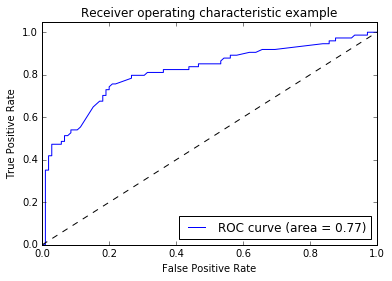

In [162]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()